In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob, os
import numpy as np
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import psutil


(17931, 96, 96) (6000, 3)


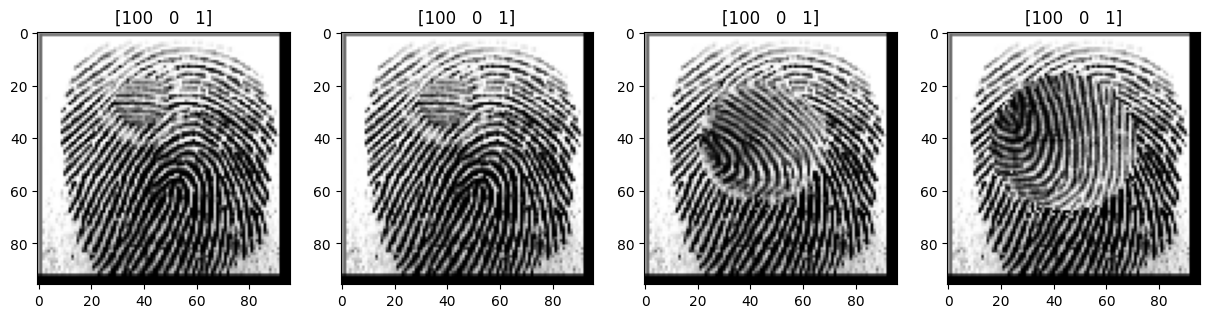

In [2]:
x_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_medium.npz')['data']
x_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_hard.npz')['data']
y_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_real.npy')
y_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_easy.npy')
y_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_medium.npy')
y_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)

plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)

plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)

plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)

plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')


C:\Users\h4uh4\AppData\Roaming\Python\Python310\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


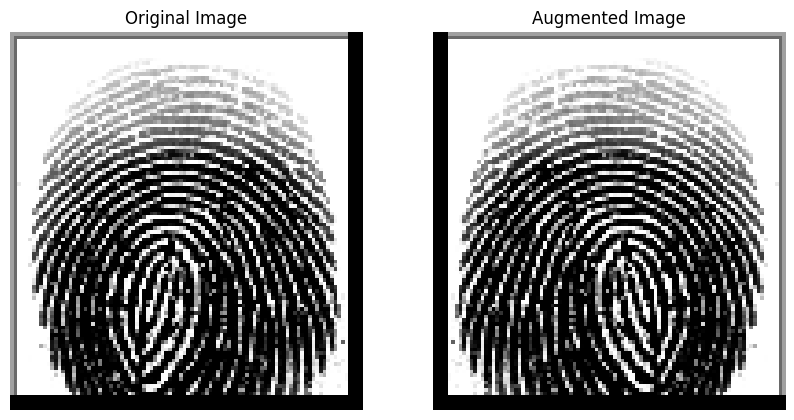

In [ ]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A


image = cv2.imread('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/Real/1__M_Left_index_finger.BMP')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, rotate=(-5, 5), p=0.7),

])






augmented = augment(image=image)
augmented_image = augmented['image']


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [ ]:

x_real = x_real[:len(y_real)]


x_data = np.concatenate([x_real, x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_real, y_easy, y_medium, y_hard], axis=0)

print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")


half_size = len(x_data) // 2

x_data_half = x_data[:half_size]
y_data_half = y_data[:half_size]

print(f"x_data_half shape: {x_data_half.shape}")
print(f"y_data_half shape: {y_data_half.shape}")



assert x_data_half.shape[0] == y_data_half.shape[0], "Jumlah sample x_data dan y_data tidak sama!"


x_temp, x_test, y_temp, y_test = train_test_split(x_data_half, y_data_half, test_size=0.2, random_state=42)


x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)


print(f"Train set size: {x_train.shape[0]} samples")
print(f"Validation set size: {x_val.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")


x_data shape: (55270, 96, 96)
y_data shape: (55270, 3)
x_data_half shape: (27635, 96, 96)
y_data_half shape: (27635, 3)
Train set size: 16581 samples
Validation set size: 5527 samples
Test set size: 5527 samples


In [ ]:

x_train = np.expand_dims(x_train, -1).astype('float32') / 255.
x_val = np.expand_dims(x_val, -1).astype('float32') / 255.
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.


In [ ]:

def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)


x_train_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_train])
x_val_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_val])
x_test_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_test])
import psutil
print(f"Memory usage: {psutil.virtual_memory().percent}%")



Memory usage: 80.6%


In [ ]:
def apply_sobel_filter_batch(images_batch):
    return np.array([apply_sobel_filter(img.squeeze()) for img in images_batch])


batch_size = 25
x_train_sobel = []
for i in range(0, len(x_train), batch_size):
    x_train_sobel.append(apply_sobel_filter_batch(x_train[i:i+batch_size]))


x_train_sobel = np.concatenate(x_train_sobel, axis=0)


x_val_sobel = []
for i in range(0, len(x_val), batch_size):
    x_val_sobel.append(apply_sobel_filter_batch(x_val[i:i+batch_size]))
x_val_sobel = np.concatenate(x_val_sobel, axis=0)

x_test_sobel = []
for i in range(0, len(x_test), batch_size):
    x_test_sobel.append(apply_sobel_filter_batch(x_test[i:i+batch_size]))
x_test_sobel = np.concatenate(x_test_sobel, axis=0)
print(f"Memory usage: {psutil.virtual_memory().percent}%")



Memory usage: 80.6%


In [ ]:
import gc


gc.collect()


5239

In [ ]:

x_train_sobel = np.expand_dims(x_train_sobel, -1).astype('float32') / np.nanmax(x_train_sobel)
x_val_sobel = np.expand_dims(x_val_sobel, -1).astype('float32') / np.nanmax(x_val_sobel)
x_test_sobel = np.expand_dims(x_test_sobel, -1).astype('float32') / np.nanmax(x_test_sobel)


In [ ]:
from tensorflow.keras.utils import Sequence


class PairGenerator(Sequence):
    def __init__(self, x, y, x_real, y_real, batch_size=32, augment_fn=None):
        self.x = x
        self.y = y
        self.x_real = x_real
        self.y_real = y_real
        self.batch_size = batch_size
        self.augment_fn = augment_fn


        self.label_real_dict = {}
        for idx, label in enumerate(self.y_real):
            key = ''.join(label.astype(str)).zfill(6)
            if key not in self.label_real_dict:
                self.label_real_dict[key] = []
            self.label_real_dict[key].append(idx)

        self.label_keys = list(self.label_real_dict.keys())

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.x))

        x1_batch = self.x[start:end]
        y_batch = self.y[start:end]
        batch_size = len(x1_batch)

        x2_batch = np.empty_like(x1_batch)
        labels = np.zeros((batch_size, 1), dtype=np.float32)

        for i, label in enumerate(y_batch):
            key = ''.join(label.astype(str)).zfill(6)

            if random.random() > 0.5 and key in self.label_real_dict:
                idx = random.choice(self.label_real_dict[key])
                x2 = self.x_real[idx]
                labels[i] = 1.
            else:
                while True:
                    unmatch_key = random.choice(self.label_keys)
                    if unmatch_key != key:
                        idx = random.choice(self.label_real_dict[unmatch_key])
                        x2 = self.x_real[idx]
                        break
                labels[i] = 0.

            x2_batch[i] = x2


            if self.augment_fn:
                x1_batch[i] = self.augment_fn(image=x1_batch[i].squeeze())['image'][..., np.newaxis]
                x2_batch[i] = self.augment_fn(image=x2_batch[i].squeeze())['image'][..., np.newaxis]

        return (x1_batch, x2_batch), labels


pair_generator = PairGenerator(x_train_sobel, y_train, x_train_sobel, y_train, batch_size=32)


(x1_batch, x2_batch), labels = pair_generator[0]

In [ ]:

def build_feature_model(input_shape=(96, 96, 1)):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model


x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))


feature_model = build_feature_model()
f1 = feature_model(x1)
f2 = feature_model(x2)


diff = layers.Subtract()([f1, f2])


x = layers.Dense(128, activation='relu')(diff)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)


model = models.Model(inputs=[x1, x2], outputs=output)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64)        │  8,012,736 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 64)        │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,029,377 (30.63 MB)

 Trainable params: 8,029,377 (30.63 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_gen = PairGenerator(x_train_sobel, y_train, x_train_sobel, y_train, batch_size=32, augment_fn=augment)
val_gen = PairGenerator(x_val, y_val, x_val, y_val, batch_size=32, augment_fn=None)


In [ ]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


Batch 1:
x1 batch shape: (32, 96, 96, 1)
x2 batch shape: (32, 96, 96, 1)
Labels shape: (32, 1)


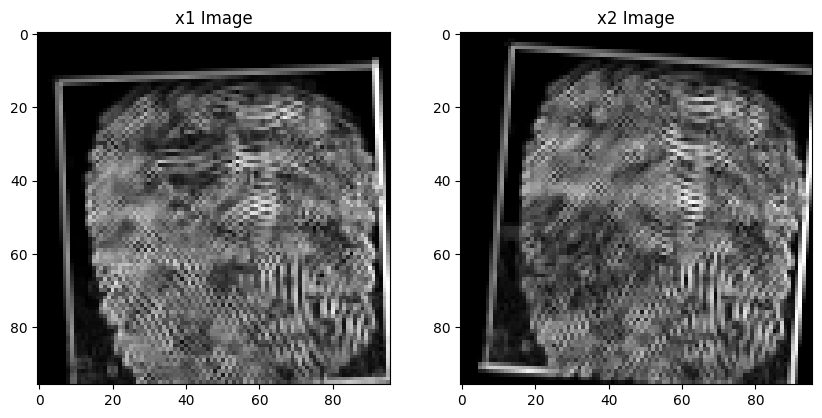

Batch 2:
x1 batch shape: (32, 96, 96, 1)
x2 batch shape: (32, 96, 96, 1)
Labels shape: (32, 1)


In [ ]:
import matplotlib.pyplot as plt


for i, (inputs, labels) in enumerate(train_gen):

    print(f"Batch {i + 1}:")
    print(f"x1 batch shape: {inputs[0].shape}")
    print(f"x2 batch shape: {inputs[1].shape}")
    print(f"Labels shape: {labels.shape}")


    if i == 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(inputs[0][0].squeeze(), cmap='gray')
        plt.title('x1 Image')

        plt.subplot(1, 2, 2)
        plt.imshow(inputs[1][0].squeeze(), cmap='gray')
        plt.title('x2 Image')

        plt.show()


    if i >= 1:
        break

In [ ]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('nonkernel_siamese_best.h5', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  
    callbacks=[checkpoint, early_stop, lr_scheduler],
    verbose=2  
)




Epoch 1/5


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


519/519 - 228s - 439ms/step - accuracy: 0.7197 - auc_1: 0.7808 - loss: 0.5725 - val_accuracy: 0.8440 - val_auc_1: 0.9212 - val_loss: 0.3891 - learning_rate: 1.0000e-03
Epoch 2/5


519/519 - 226s - 435ms/step - accuracy: 0.7596 - auc_1: 0.8196 - loss: 0.5095 - val_accuracy: 0.8809 - val_auc_1: 0.9227 - val_loss: 0.3234 - learning_rate: 1.0000e-03
Epoch 3/5


519/519 - 219s - 422ms/step - accuracy: 0.7560 - auc_1: 0.8116 - loss: 0.5122 - val_accuracy: 0.8791 - val_auc_1: 0.9204 - val_loss: 0.3184 - learning_rate: 1.0000e-03
Epoch 4/5


519/519 - 214s - 412ms/step - accuracy: 0.7495 - auc_1: 0.8087 - loss: 0.5124 - val_accuracy: 0.8904 - val_auc_1: 0.9257 - val_loss: 0.3011 - learning_rate: 1.0000e-03
Epoch 5/5
519/519 - 259s - 500ms/step - accuracy: 0.7460 - auc_1: 0.8022 - loss: 0.5197 - val_accuracy: 0.8864 - val_auc_1: 0.9273 - val_loss: 0.3022 - learning_rate: 1.0000e-03


In [ ]:

model.save('C:/Users/h4uh4/OneDrive/Desktop/FinalCompareFriedman/Model_Siamese/ModelSiam/sobel_siam_model.keras')




Shapes: (5527, 96, 96, 1) (5527, 96, 96, 1) (5527, 1)


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
  0%|          | 0/100 [00:00<?, ?it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step


  1%|          | 1/100 [00:22<37:41, 22.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


  2%|▏         | 2/100 [00:41<33:29, 20.50s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


  3%|▎         | 3/100 [00:59<31:26, 19.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step


  4%|▍         | 4/100 [01:17<30:08, 18.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


  5%|▌         | 5/100 [01:35<29:05, 18.38s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


  6%|▌         | 6/100 [01:53<28:52, 18.43s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


  7%|▋         | 7/100 [02:13<28:57, 18.68s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


  8%|▊         | 8/100 [02:32<28:47, 18.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


  9%|▉         | 9/100 [02:50<28:31, 18.80s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 10%|█         | 10/100 [03:08<27:39, 18.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step


 11%|█         | 11/100 [03:25<26:48, 18.07s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step


 12%|█▏        | 12/100 [03:42<26:04, 17.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step


 13%|█▎        | 13/100 [03:59<25:18, 17.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 14%|█▍        | 14/100 [04:17<25:00, 17.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 15%|█▌        | 15/100 [04:33<24:27, 17.26s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 16%|█▌        | 16/100 [04:50<23:55, 17.09s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 17%|█▋        | 17/100 [05:07<23:28, 16.97s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 18%|█▊        | 18/100 [05:23<23:04, 16.89s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 19%|█▉        | 19/100 [05:40<22:43, 16.83s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step


 20%|██        | 20/100 [05:57<22:19, 16.74s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step


 21%|██        | 21/100 [06:13<22:01, 16.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step


 22%|██▏       | 22/100 [06:30<21:41, 16.69s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step


 23%|██▎       | 23/100 [06:47<21:21, 16.65s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step


 24%|██▍       | 24/100 [07:03<21:04, 16.64s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 25%|██▌       | 25/100 [07:21<21:14, 16.99s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 26%|██▌       | 26/100 [07:39<21:30, 17.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step


 27%|██▋       | 27/100 [07:58<21:31, 17.69s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 28%|██▊       | 28/100 [08:15<21:11, 17.66s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 29%|██▉       | 29/100 [08:33<21:02, 17.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 30%|███       | 30/100 [08:51<20:49, 17.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 31%|███       | 31/100 [09:10<20:46, 18.07s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 32%|███▏      | 32/100 [09:29<20:42, 18.27s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 33%|███▎      | 33/100 [09:47<20:33, 18.40s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 34%|███▍      | 34/100 [10:06<20:09, 18.33s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 35%|███▌      | 35/100 [10:25<20:08, 18.60s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 36%|███▌      | 36/100 [10:44<20:02, 18.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 37%|███▋      | 37/100 [11:03<19:47, 18.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 38%|███▊      | 38/100 [11:22<19:31, 18.89s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 39%|███▉      | 39/100 [11:41<19:19, 19.02s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 40%|████      | 40/100 [12:00<19:01, 19.02s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 41%|████      | 41/100 [12:19<18:41, 19.01s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 42%|████▏     | 42/100 [12:38<18:18, 18.94s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step


 43%|████▎     | 43/100 [12:57<17:52, 18.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 44%|████▍     | 44/100 [13:15<17:23, 18.63s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 45%|████▌     | 45/100 [13:36<17:51, 19.48s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 46%|████▌     | 46/100 [13:55<17:20, 19.26s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step


 47%|████▋     | 47/100 [14:15<17:10, 19.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 48%|████▊     | 48/100 [14:34<16:46, 19.35s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 49%|████▉     | 49/100 [14:53<16:16, 19.14s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 50%|█████     | 50/100 [15:11<15:47, 18.95s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step


 51%|█████     | 51/100 [15:31<15:43, 19.26s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step


 52%|█████▏    | 52/100 [15:51<15:25, 19.29s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 53%|█████▎    | 53/100 [16:09<14:56, 19.08s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 54%|█████▍    | 54/100 [16:28<14:28, 18.89s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 55%|█████▌    | 55/100 [16:47<14:10, 18.91s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step


 56%|█████▌    | 56/100 [17:06<13:57, 19.04s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step


 57%|█████▋    | 57/100 [17:25<13:41, 19.10s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step


 58%|█████▊    | 58/100 [17:45<13:31, 19.33s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 59%|█████▉    | 59/100 [18:04<13:09, 19.27s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 60%|██████    | 60/100 [18:23<12:49, 19.23s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step


 61%|██████    | 61/100 [18:43<12:38, 19.46s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 62%|██████▏   | 62/100 [19:02<12:10, 19.22s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step


 63%|██████▎   | 63/100 [19:23<12:14, 19.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step


 64%|██████▍   | 64/100 [19:42<11:38, 19.42s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 65%|██████▌   | 65/100 [20:00<11:10, 19.16s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 66%|██████▌   | 66/100 [20:18<10:41, 18.86s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 67%|██████▋   | 67/100 [20:36<10:14, 18.62s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 68%|██████▊   | 68/100 [20:54<09:46, 18.34s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 69%|██████▉   | 69/100 [21:12<09:21, 18.12s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 70%|███████   | 70/100 [21:29<09:00, 18.02s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step


 71%|███████   | 71/100 [21:47<08:36, 17.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step


 72%|███████▏  | 72/100 [22:04<08:17, 17.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 73%|███████▎  | 73/100 [22:22<07:56, 17.65s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 74%|███████▍  | 74/100 [22:39<07:36, 17.58s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step


 75%|███████▌  | 75/100 [22:57<07:20, 17.63s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step


 76%|███████▌  | 76/100 [23:15<07:03, 17.65s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step


 77%|███████▋  | 77/100 [23:33<06:47, 17.71s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 78%|███████▊  | 78/100 [23:51<06:37, 18.07s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 79%|███████▉  | 79/100 [24:10<06:22, 18.21s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


 80%|████████  | 80/100 [24:30<06:12, 18.61s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 81%|████████  | 81/100 [24:48<05:50, 18.43s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 82%|████████▏ | 82/100 [25:06<05:29, 18.30s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step


 83%|████████▎ | 83/100 [25:24<05:11, 18.31s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 84%|████████▍ | 84/100 [25:43<04:56, 18.56s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 85%|████████▌ | 85/100 [26:02<04:38, 18.55s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 86%|████████▌ | 86/100 [26:21<04:22, 18.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 87%|████████▋ | 87/100 [26:39<04:01, 18.58s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 88%|████████▊ | 88/100 [26:58<03:43, 18.59s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 89%|████████▉ | 89/100 [27:16<03:24, 18.56s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step


 90%|█████████ | 90/100 [27:34<03:02, 18.25s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step


 91%|█████████ | 91/100 [27:51<02:42, 18.11s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 92%|█████████▏| 92/100 [28:10<02:26, 18.27s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 93%|█████████▎| 93/100 [28:28<02:08, 18.34s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step


 94%|█████████▍| 94/100 [28:46<01:49, 18.23s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step


 95%|█████████▌| 95/100 [29:05<01:31, 18.21s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step


 96%|█████████▌| 96/100 [29:23<01:12, 18.22s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


 97%|█████████▋| 97/100 [29:42<00:55, 18.39s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step


 98%|█████████▊| 98/100 [30:01<00:37, 18.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


 99%|█████████▉| 99/100 [30:21<00:18, 18.92s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step


100%|██████████| 100/100 [30:41<00:00, 18.41s/it]

Bootstrap AUC mean: 0.9211
95% Confidence Interval: [0.9136, 0.9289]
Indices dipilih: [ 0 24 49 74 99]
Nilai AUC diambil: [0.92190633 0.91693229 0.92171644 0.92748569 0.91614289]


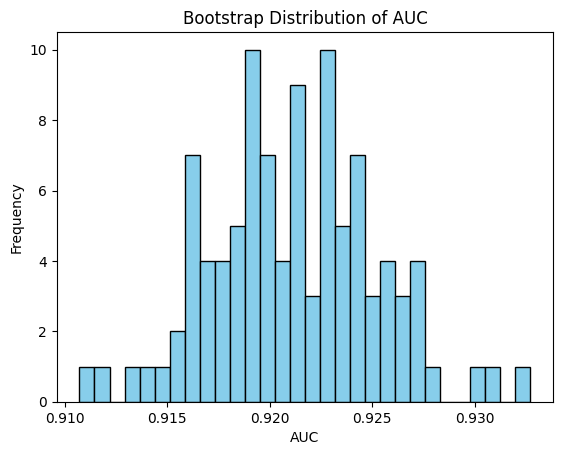

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm


test_gen = PairGenerator(x_test_sobel, y_test, x_test_sobel, y_test, batch_size=32, augment_fn=augment)

x1_list, x2_list, y_list = [], [], []
for i in range(len(test_gen)):
    (x1_batch, x2_batch), y_batch = test_gen[i]
    x1_list.append(x1_batch)
    x2_list.append(x2_batch)
    y_list.append(y_batch)

x_test_1 = np.concatenate(x1_list, axis=0)
x_test_2 = np.concatenate(x2_list, axis=0)
y_test_full = np.concatenate(y_list, axis=0)
y_test_full = y_test_full[:len(x_test_1)]

print("Shapes:", x_test_1.shape, x_test_2.shape, y_test_full.shape)


model_local = load_model('C:/Users/h4uh4/OneDrive/Desktop/FinalCompareFriedman/Model_Siamese/ModelSiam/sobel_siam_model.keras')

B = 100
n = len(x_test_1)
num_classes = len(np.unique(y_test_full))
results = []

for seed in tqdm(range(B), total=B):
    np.random.seed(seed)
    idx = np.random.choice(n, size=n, replace=True)
    x1_bs, x2_bs, y_bs = x_test_1[idx], x_test_2[idx], y_test_full[idx]

    y_pred_probs = model_local.predict([x1_bs, x2_bs], batch_size=32)
    y_bs_bin = label_binarize(y_bs, classes=range(num_classes))

    auc = roc_auc_score(y_bs_bin, y_pred_probs, multi_class='ovr', average='macro')
    results.append(auc)

auc_scores = np.array(results)
mean_auc = np.mean(auc_scores)
ci_lower, ci_upper = np.percentile(auc_scores, [2.5, 97.5])

print(f"Bootstrap AUC mean: {mean_auc:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


indices = np.linspace(0, len(auc_scores) - 1, 5, dtype=int)
sampled_aucs = auc_scores[indices]

print("Indices dipilih:", indices)
print("Nilai AUC diambil:", sampled_aucs)


with open("sobel_bootstrap_auc_results.txt", "w") as f:
    f.write("Sampled 5 AUC values (berjarak):\n")
    for val in sampled_aucs:
        f.write(f"{val:.6f}\n")
    f.write("\n")
    f.write(f"Bootstrap AUC mean: {mean_auc:.4f}\n")
    f.write(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]\n\n")
    f.write("All Bootstrap AUC scores:\n")
    for val in auc_scores:
        f.write(f"{val:.6f}\n")


plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Bootstrap Distribution of AUC')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.show()


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.8810 - auc_1: 0.9319 - loss: 0.3199
Test Loss: 0.3264378011226654
Test Accuracy: 0.8771485686302185
Test AUC: 0.9312434196472168


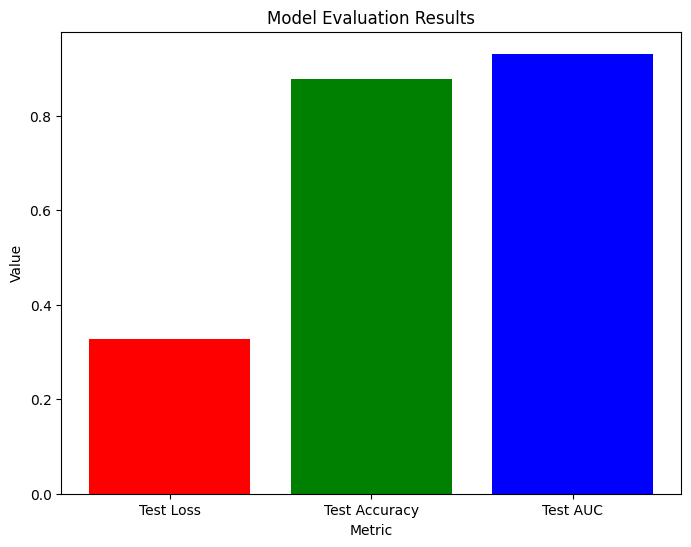

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_gen = PairGenerator(x_test_sobel, y_test, x_test_sobel, y_test, batch_size=32, augment_fn=None)


test_loss, test_accuracy, test_auc = model.evaluate(test_gen)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


results = [test_loss, test_accuracy, test_auc]
labels = ['Test Loss', 'Test Accuracy', 'Test AUC']


plt.figure(figsize=(8, 6))
plt.bar(labels, results, color=['red', 'green', 'blue'])


plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Evaluation Results')


plt.show()
